# PHYS3112: Double Slit Interference Assignment

## Wavelength from Interference Pattern
From the double slit interference data collected in the lab, let us work out the average spacing between maxima $w$.

To do this, we will use the fourier transform, by taking our equally spaced data points (in $\mathrm{mm}$) and transforming them into a frequency (in $\mathrm{mm}^{-1}$). We can then use the maximum frequency as well as its FWHM to give an estimate for the spacing between maxima.

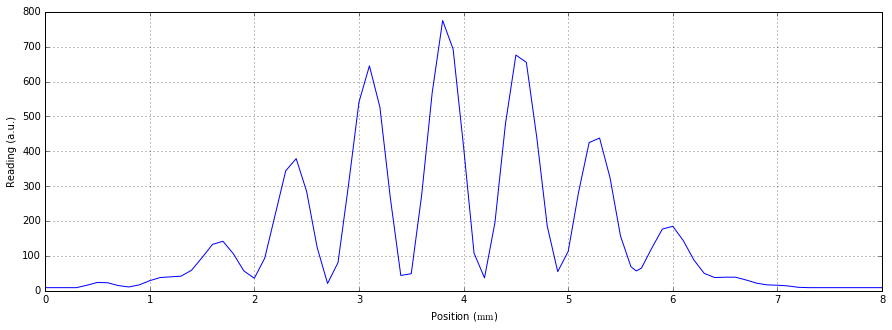

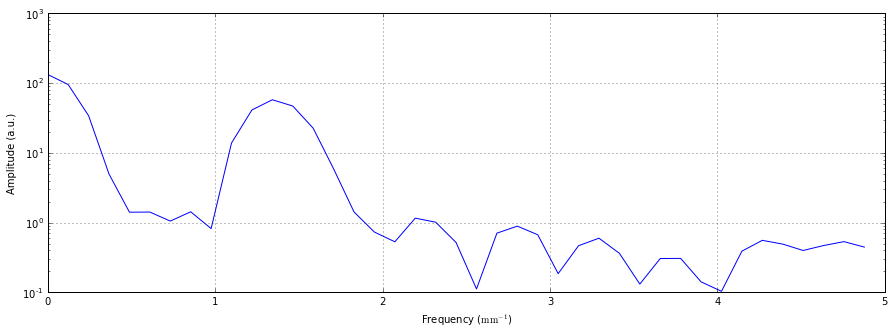

In [1]:
import matplotlib.pyplot as plot
import numpy, scipy.fftpack, scipy.signal

plot.rcParams["figure.figsize"] = (15, 5)

pos, reading = numpy.loadtxt("wave-double-slit.tsv", delimiter = "\t", skiprows = 1, unpack = True)

plot.plot(pos, reading)
plot.xlabel(r"Position ($\mathrm{mm}$)")
plot.ylabel("Reading (a.u.)")
plot.grid()
plot.show()

def fft(y):
    return numpy.abs(scipy.fftpack.fft(numpy.multiply(scipy.signal.hamming(len(y)), y)))[0:len(y) // 2] / len(y)

freq = scipy.fftpack.fftfreq(len(pos), pos[1] - pos[0])[0:len(pos) // 2]
readingFft = fft(reading)

plot.semilogy(freq, readingFft)
plot.xlabel(r"Frequency ($\mathrm{mm}^{-1}$)")
plot.ylabel("Amplitude (a.u.)")
plot.grid()
plot.show()

One can clearly see a maxima at around $1.4(3) \:\mathrm{mm}^{-1}$, so lets use that as our initial guess to find the maxima and then FWHM. We can then transform those values back to spacing values by taking their reciprocal.

In [2]:
from scipy.signal import argrelmax

maximaIndex = [i for i in argrelmax(readingFft, order = 3)[0] if abs(freq[i] - 1.4) < 0.3][0]
maximaFreq = freq[maximaIndex]

# Find FWHM
for i in reversed(range(0, maximaIndex)):
    if readingFft[i] < readingFft[maximaIndex] / 2:
        maximaFreqLoHM = freq[i]
        break
for i in range(maximaIndex, len(readingFft)):
    if readingFft[i] < readingFft[maximaIndex] / 2:
        maximaFreqHiHM = freq[i]
        break

w = 1 / maximaFreq # Average spacing
Dw = (1 / maximaFreqLoHM - 1 / maximaFreqHiHM) / 2
print("w = {:.2f}({:.0f}) mm".format(w, Dw * 100))

w = 0.75(14) mm


Now that we have the maxima spacing, we can calculate the wavelength of the laser light.

From the [lab report](lab.pdf), we have the following basic paramaters of the system:
$$\begin{align*}
S &= 0.457 \:\mathrm{mm} \\
L &= 500(2) \:\mathrm{mm}
\end{align*}$$
where $S$ is the slit seperation and $L$ is the slit-to-detector distance.

From comparing phase differences in paths, we obtain the following equations relating maxima to angular displacement (in the far field):
$$S \sin \theta = n \lambda$$

$\theta$ can be related to $L$ and $w$ by:
$$\theta = \tan^{-1} \frac{n w}{L}$$

Combining the two and solving for $\lambda$, we obtain:
$$\lambda = \frac{S}{n} \sin \tan^{-1} \frac{n w}{L}$$

With the small angle approximation, we can simplify to:
$$\lambda \approx \frac{S w}{L}$$

To calculate the corresponding errors, we just use the standard rule:
$$\begin{align*}
\Delta f(n_1, n_2, ..., n_k) &= \sqrt{\sum_{i = 1}^k \left(\frac{\partial f}{\partial n_i} \Delta n_i\right)^2} \\
\therefore \Delta \lambda &\approx \sqrt{\left(\frac{S}{L} \Delta w\right)^2 + \left(\frac{S w}{L^2} \Delta L\right)^2}
\end{align*}$$

In [3]:
S = 0.457
L = 500
DL = 2

wavelength = S * w / L
Dwavelength = numpy.linalg.norm((S / L * Dw, S * w / L**2 * DL))
print("λ = {:.2f}({:.0f}) μm".format(wavelength * 1e3, Dwavelength * 1e5))

λ = 0.68(13) μm


## Interference Pattern from Experiment Parameters
If we neglect diffraction and polarisation, we can consider the double slit interference to be the result of two infinitely long, infinitesimally thin, parallel line emitters of perfectly coherent light separated by distance $S$. If these lines are parallel to the $z$-axis, then by symmetry, this problem can be reduced down to two point isotropic emitters in the $x$-$y$ plane, which is what we will do here.

Each point emitter will be emitting radiation with the following wavefunction:
$$\Psi = U e^{i (\mathbf{k} \cdot (\mathbf{r} - \mathbf{r}_0) - \omega t)}$$
where $U$ is the complex amplitude, $\mathbf{k}$ is the vector wavenumber, $\mathbf{r}_0$ is the spatial displacement of the emitter, and $\omega$ the angular frequency.

The magnitude of $\mathbf{k}$ and $\omega$ are both only dependent on the frequency and phase velocity of the radiation, as follows:
$$\begin{align*}
|\mathbf{k}| &= k = \frac{2 \pi f}{c} \\
\omega &= 2 \pi f
\end{align*}$$

The direction of $\mathbf{k}$ always points away from the emitter, so it is:
$$\hat{\mathbf{k}} = \frac{\mathbf{r} - \mathbf{r}_0}{|\mathbf{r} - \mathbf{r}_0|}$$

If we make the substitution $\mathbf{r}' = \mathbf{r} - \mathbf{r}_0$ (which corresponds to the vector distance from the source), we can get a simpler expression for $\mathbf{k} \cdot (\mathbf{r} - \mathbf{r}_0)$:
$$\mathbf{k} \cdot \mathbf{r}' = k \frac{\mathbf{r}'^2}{|\mathbf{r}'|} = k |\mathbf{r}'|$$

In [4]:
import math

def createWavefunction(U, f, c, r_0):
    from autograd import numpy # Use autograd's numpy so we can differentiate this function
    kMag = 2 * math.pi * f / c
    omega = 2 * math.pi * f
    def wavefunction(t, r):
        rPrime = numpy.linalg.norm(r - r_0)
        return U * numpy.exp((kMag * rPrime - omega * t) * 1j)

    return wavefunction

Since light is linear, we can simply add the wavefunctions of the emitters to obtain an interference pattern:
$$\Psi = U_1 e^{i (k_1 |\mathbf{r}'| - \omega_1 t)} + U_2 e^{i (k_2 |\mathbf{r}'| - \omega_2 t)}$$

This gives us an interference pattern with phase information, however, which isn't what we're interested in. Instead, we're more interested in its intensity, which is proportional to the squared modulus multiplied by a projection factor:
$$I \propto \overline{\Psi} \Psi \left|\hat{\mathbf{S}} \cdot \hat{\mathbf{n}}\right|$$
where $\hat{\mathbf{S}}$ is the direction of energy propagation and $\hat{\mathbf{n}}$ is the surface normal of the receiving surface.

For simplicity, we will assume the direction of energy propagation is identical to that of the phases, so $\hat{\mathbf{S}} = \hat{\mathbf{k}}$. To find $\mathbf{k}$, we simply take the gradient of the argument of the wavefunction (which then needs to be normalised to get the unit vector):
$$\mathbf{k} = \nabla \arg \Psi$$

In [5]:
import autograd
from functools import reduce

def interfereWavefunctions(wavefunctions):
    def wavefunction(t, r):
        return reduce(lambda a, b: a + b(t, r), wavefunctions, 0)
    return wavefunction

def getIntensity(wavefunction):
    def intensity(t, r, n):
        amplitude = wavefunction(t, r)
        k = autograd.grad(lambda r: autograd.numpy.angle(wavefunction(t, r)))(r)
        k /= numpy.linalg.norm(k)
        projection = numpy.abs(numpy.dot(k, n))
        return numpy.real(numpy.conj(amplitude) * amplitude) * projection
    return intensity

Finally we can introduce the slit separation $S$ into our solution, by placing our two point emitters at $\mathbf{r}_0 = (0, \pm\frac{S}{2})$. At this point, we will also assume the two emitters have the same complex amplitude $1$, as well as emit at the same frequency. This allows us to assume the intensity does not vary with time (since if we solve the intensity equation symbolically, the $t$ variable drops out), so we sample the intensity at $t = 0$.

In [6]:
def doubleSlitIntensity(f, c, S):
    wavefunction = interfereWavefunctions((
        createWavefunction(1, f, c, numpy.array((0, S / 2))),
        createWavefunction(1, f, c, numpy.array((0, -S / 2)))
    ))
    intensity = getIntensity(wavefunction)
    
    t = 0
    return lambda r, n: intensity(t, r, n)

### 5 GHz Wifi
From the assignment spec, we have system parameters of:
$$\begin{align*}
f &= 5 \:\mathrm{GHz} \\
c &= 299792458 \:\mathrm{m \cdot s^{-1}} \\
S &= 5 \:\mathrm{m} \\
L &= 200 \:\mathrm{m}
\end{align*}$$

We simply take the intensity function with the above $f$, $c$, and $S$, and then scan across the line at $x = L$ to get the intensity on the screen. The normal vector of this screen is simply:
$$\hat{\mathbf{n}} = \hat{\mathbf{x}}$$

One can see that at larger displacements, the intensity starts to lower. This is because the incoming beam is not a plane wave, but actually slightly divergent, so larger displacements will be illuminated at a lower intensity due to the angle the beam intersects the plane at.

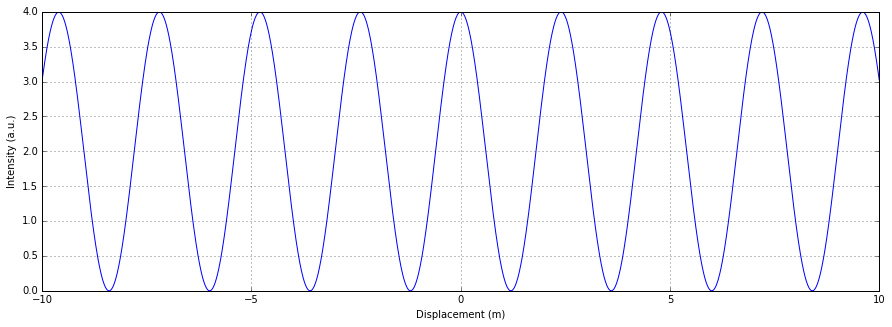

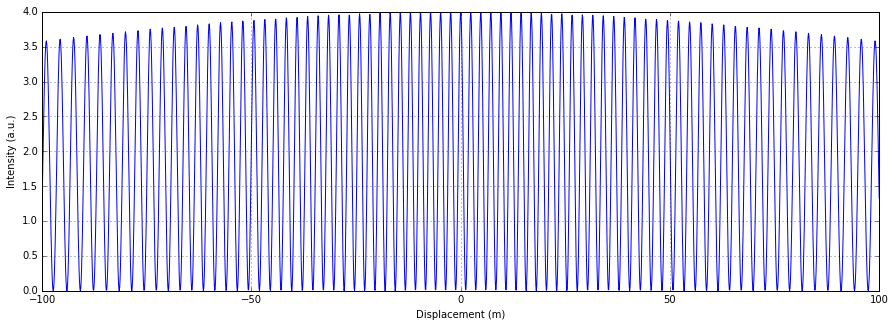

In [7]:
intensity = doubleSlitIntensity(5e9, 299792458, 5)

y1 = numpy.linspace(-10, 10, 2000)
I1 = [intensity(numpy.array((200, y)), numpy.array((1, 0))) for y in y1]

y2 = numpy.linspace(-100, 100, 2000)
I2 = [intensity(numpy.array((200, y)), numpy.array((1, 0))) for y in y2]

plot.plot(y1, I1)
plot.xlabel("Displacement (m)")
plot.ylabel("Intensity (a.u.)")
plot.grid()
plot.show()

plot.plot(y2, I2)
plot.xlabel("Displacement (m)")
plot.ylabel("Intensity (a.u.)")
plot.grid()
plot.show()

### Electrons
Once again we have:
$$\begin{align*}
f &= \frac{c^2 m}{h} \approx 1.235590 \:\mathrm{THz} \\
c &\approx 29979.2  \:\mathrm{m \cdot s^{-1}} \\
S &= 10^{-6} \:\mathrm{m} \\
L &= 15 \:\mathrm{m}
\end{align*}$$

We can neglect the effects of special relativity due to the low speed of the electron.

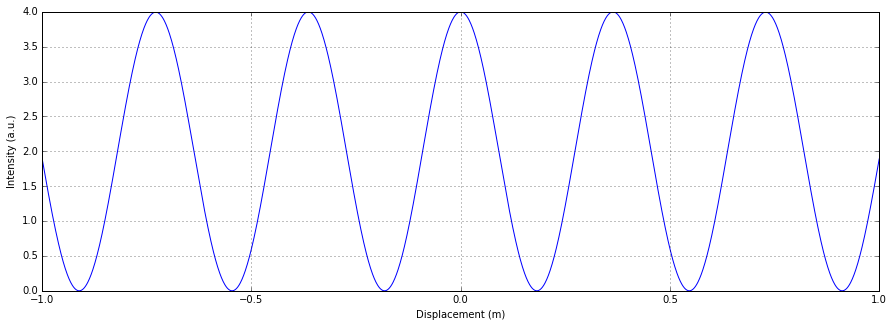

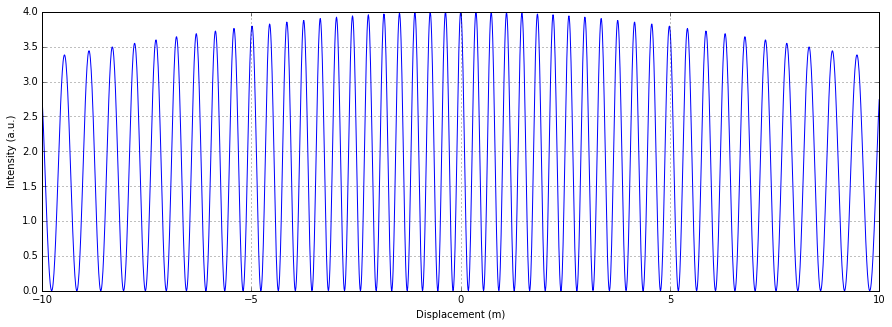

In [8]:
intensity = doubleSlitIntensity(1.235590e12, 29979.2, 1e-6)

y1 = numpy.linspace(-1, 1, 2000)
I1 = [intensity(numpy.array((15, y)), numpy.array((1, 0))) for y in y1]

y2 = numpy.linspace(-10, 10, 2000)
I2 = [intensity(numpy.array((15, y)), numpy.array((1, 0))) for y in y2]

plot.plot(y1, I1)
plot.xlabel("Displacement (m)")
plot.ylabel("Intensity (a.u.)")
plot.grid()
plot.show()

plot.plot(y2, I2)
plot.xlabel("Displacement (m)")
plot.ylabel("Intensity (a.u.)")
plot.grid()
plot.show()

### 5892 Angstrom Laser
$$\begin{align*}
f &\approx 508.8 \:\mathrm{THz} \\
c &= 299792458 \:\mathrm{m \cdot s^{-1}} \\
S &= 30 \times 10^{-6} \:\mathrm{m}
\end{align*}$$

Instead of a flat screen this time, we now have a semicircular screen of radius $1.5 \:\mathrm{m}$ and displacement of $(13.5, 0) \:\mathrm{m}$. Probably the best way to project this curved surface to this flat monitor would be to project onto the $\theta$ axis of the semicircle.

To do this, we need to find a $\theta \to \mathbf{r}$ mapping, which is trivial:
$$\mathbf{r} = ((1.5 \cos \theta + 13.5) \:\hat{\mathbf{x}} + 1.5 \sin \theta \:\hat{\mathbf{y}}) \:\mathrm{m}$$

The corresponding surface normal is:
$$\hat{\mathbf{n}} = \cos \theta \:\hat{\mathbf{x}} + \sin \theta \:\hat{\mathbf{y}}$$

We extend the surface slightly past $\theta = \frac{\pi}{2}$, since the incoming beam is not a plane wave but slightly divergent, and hence can illuminate more of a circle.

Note that with our current model, we are assuming no shadows are cast. However, in this case, the edges of our surface will start shadowing one of the point sources, resulting in a loss of interference pattern near the edges. Our solution to this is to just say that our screen is a 100% transparent, index-matched screen that still somehow is able to measure intensity.

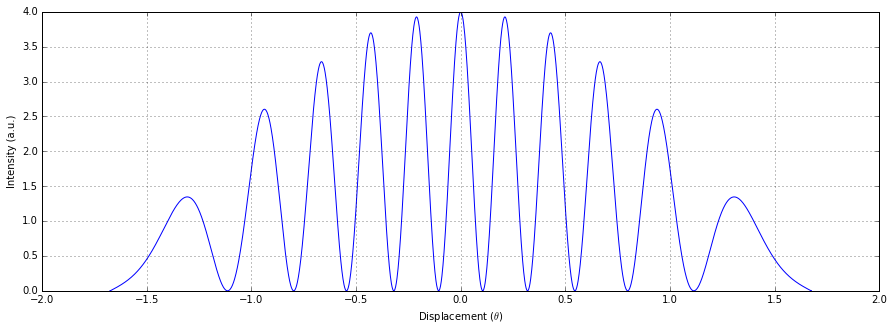

In [9]:
intensity = doubleSlitIntensity(508.8e12, 299792458, 30e-6)

r = lambda theta: numpy.array((1.5 * math.cos(theta) + 13.5, 1.4 * math.sin(theta)))
n = lambda theta: numpy.array((math.cos(theta), math.sin(theta)))

# theta extends slightly past pi / 2 because the 
theta = numpy.linspace(-1.067 * math.pi / 2, 1.067 * math.pi / 2, 2000)
I = [intensity(r(theta), n(theta)) for theta in theta]

plot.plot(theta, I)
plot.xlabel(r"Displacement ($\theta$)")
plot.ylabel("Intensity (a.u.)")
plot.grid()
plot.show()